In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from tqdm import *

import sys
sys.path.append("..") 
import ndac

from keras import backend as K
from ndac.data_processing import quantile_classify

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DF_prest = pd.read_csv('../dataframes/DF_prest.csv',index_col=0)
print('Number of prESTs:', len(DF_prest))
DF_prest.head()

Number of prESTs: 45206


,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124


# Preprocessing
[Back to Top](#Table-of-Contents)

There are very few highly expressed proteins when there are >4 prESTs from the same uniprot, as these were peptides that were difficult to express

45206 samples input.
11302 samples in class 0
11301 samples in class 1
22603 samples removed.


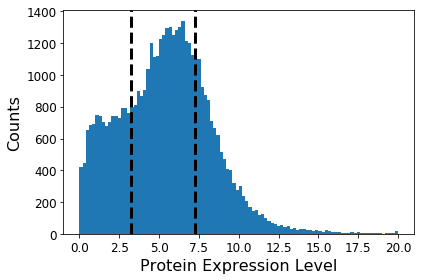

In [3]:
df, hist = quantile_classify(DF_prest['conc_cf'], DF_prest['aa_seq'],
                             [0.25, 0.75], drop_class=[1])

In [4]:
DF_prest['expressed'] = df['class']
DF_prest = DF_prest.dropna()

In [6]:
df_counts = pd.DataFrame(data=0, columns=['high','low'],
                         index=set(
                             DF_prest.groupby('uniprot_id').count().aa_seq)
                        )

In [7]:
for name, group in tqdm(DF_prest.groupby('uniprot_id')):
    n = len(group.conc_cf)
    df_counts.loc[n,'high'] += sum(group.expressed==True)
    df_counts.loc[n,'low'] += sum(group.expressed==False)

100%|██████████| 12851/12851 [00:14<00:00, 902.33it/s]


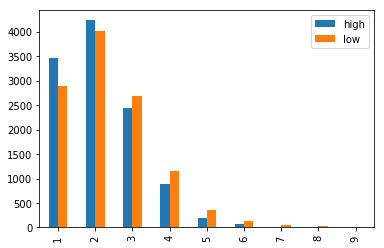

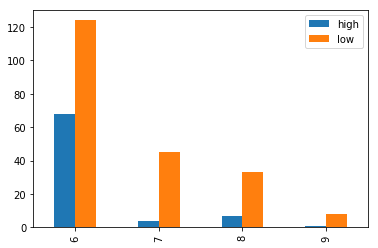

In [8]:
df_counts.plot(kind='bar')
df_counts[df_counts.index > 5].plot(kind='bar')

Only keep proteins that have <5 prESTs per protein

In [9]:
low_num_uniprots = DF_prest.groupby('uniprot_id').count().aa_seq[DF_prest.groupby('uniprot_id').count().aa_seq < 5].index.tolist()
DF_prest_filtered = DF_prest[DF_prest.uniprot_id.isin(low_num_uniprots)]

prest_id
1    6354
2    4122
3    1712
4     511
Name: aa_seq, dtype: int64


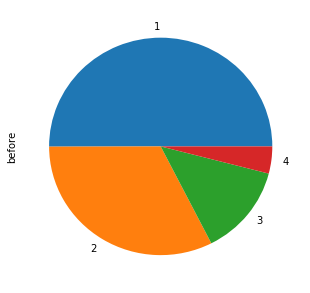

In [10]:
# Number of prESTs per protein
pie_var = DF_prest_filtered.groupby('uniprot_id').count().groupby('prest_id').count().aa_seq
pie = (pie_var).plot(kind='pie',fontsize=10,figsize=(5,5),label='before')
print(pie_var)

### Train-Test Split
[Back to Top](#Table-of-Contents)

In [11]:
# Get the number of prESTs per each uniprot
uniprot_counts = DF_prest_filtered.groupby('uniprot_id').count().prest_id

# Add all uniprots with a single prEST to the training set
training_uniprots = uniprot_counts[uniprot_counts == 1].index.tolist()

# Randomly pick 1/4 of other uniprots and add them to training set
random.seed(10)
other_uniprots = uniprot_counts[uniprot_counts > 1].index.tolist()


In [12]:
training_uniprots += random.sample(other_uniprots, round(len(other_uniprots)/4))

# Add all remaining uniprots to test set
testing_uniprots = list(set(uniprot_counts.index.tolist()) - set(training_uniprots))

In [13]:
print('Total number of proteins:', len(DF_prest_filtered.uniprot_id.unique()))
print('Number of training proteins:', len(training_uniprots))
print('Number of testing proteins:', len(testing_uniprots))

Total number of proteins: 12699
Number of training proteins: 7940
Number of testing proteins: 4759


In [14]:
# Add all prESTs in training uniprots to training set
DF_train = DF_prest_filtered[DF_prest_filtered.uniprot_id.isin(training_uniprots)]
DF_train.loc[:,'status'] = ['Train']*len(DF_train)
print('Training set size:', len(DF_train))

# Repeat for test set
DF_test = DF_prest_filtered[DF_prest_filtered.uniprot_id.isin(testing_uniprots)]
DF_test.loc[:,'status'] = ['Test']*len(DF_test)
print('Testing set size:', len(DF_test))

Training set size: 10216
Testing set size: 11562


/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
DF_train.to_csv('DF_train.csv')
DF_test.to_csv('DF_test.csv')